In [199]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN

#from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
import utils
plt.ion()
plt.show()

import matplotlib
import tools as t

from scipy.sparse import csr_matrix
from scipy import spatial
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.csgraph import connected_components
from sklearn.metrics import pairwise_kernels
from networkx.algorithms.cuts import conductance
import networkx as nx 
import pickle
from scipy.stats import pearsonr
from scipy import spatial
sns.set_style('darkgrid')
%matplotlib inline

# DBSCAN Clustering:

The DBSCAN algorithm can be abstracted into the following steps:

1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.
3. Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

_Advantages_
1. Fast, works with large databases
2. Can handle noisy points
3. Can find clusters of arbitrary shapes 
4. Can find number of clusters given eps

Goal: to separate clusters of high density from low density regions

![DBSCAN Illustration](DBSCAN.png)

In [200]:

epoch_subsample = np.unique(np.round(np.logspace(np.log10(1), np.log10(9999), num=100, endpoint=True)).astype(int))
data_tishby = np.load('/home/zz452/cluster/data/modelTishby_0_layer_data.p')


def get_nclusters(epsilon = 0.1, lndx = -2):
    layer = data_tishby[lndx] 

    nb_clusters = []
    for idx in range(len(layer)):

        X = layer[idx,:,:]
        
        clustering = DBSCAN(eps = epsilon, min_samples=1).fit(X)
        y_pred = clustering.labels_
        cluster_labels = np.unique(y_pred)


        if -1 in cluster_labels:
            nclusters = len(cluster_labels)-1
        else:
            nclusters = len(cluster_labels)
        nb_clusters.append(nclusters)
        #print(nclusters)
        #print(np.count_nonzero(y_pred!=-1))
    return nb_clusters


In [201]:
def get_connected_components(epsilon = 0.1, lndx = -2):
    layer = data_tishby[lndx] 

    nb_clusters = []
    for idx in range(len(layer)):

        X = layer[idx,:,:]
        M_d = spatial.distance_matrix(X,
                              X,
                              p=2)
        mask = M_d<epsilon
        n_components, labels = connected_components(csgraph= mask, directed=False, return_labels=True)
        nb_clusters.append(n_components)
        
    return nb_clusters

def get_binned_MI(binsize, lndx = -2):
    layer = data_tishby[lndx] 
    
    def get_unique_probs(x):
        uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
        _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
        return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


    def bin_calc_information2(layerdata, binsize):
        # This is even further simplified, where we use np.floor instead of digitize
        def get_h(d):
            digitized = np.floor(d / binsize).astype('int')
            p_ts, _ = get_unique_probs( digitized )
            return -np.sum(p_ts * np.log(p_ts))

        H_LAYER = get_h(layerdata)
        return H_LAYER

    binxm = np.zeros(len(layer))
    for idx in range(len(layer)):
        binxm[idx] = bin_calc_information2(layer[idx,:,:], binsize)
    return binxm

_Layer 5 (Dims: 3)_

In [178]:
points = data_tishby[-2][0,:,:]
M_d = spatial.distance_matrix(points,
                              points,
                              p=2)**2


(0.0025596002242259663, 0.0011386118303974844)

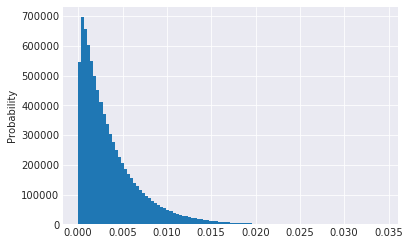

In [179]:
dists = M_d[np.tril_indices(points.shape[0], k = -1)]
%matplotlib inline
plt.hist(dists,  bins=100)
plt.ylabel('Probability');
np.median(dists), np.quantile(dists, 0.25)

Correlation between binned MI and number of clusters:  (0.6923630364733327, 2.990477179851656e-13)


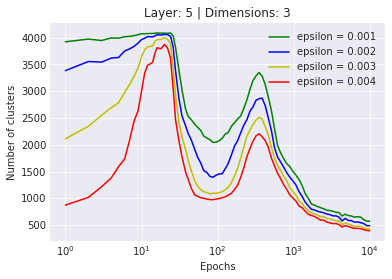

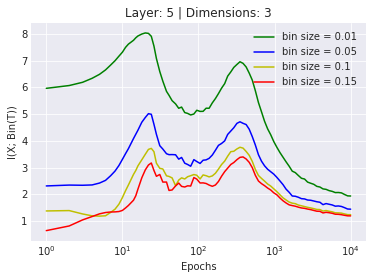

In [355]:
nclusters1 = get_nclusters(epsilon = 0.0012)   #eps = 0.03 (max dist),  4(min_samples)
nclusters2 = get_nclusters(epsilon = 0.002)
nclusters3 = get_nclusters(epsilon = 0.003)
nclusters4 = get_nclusters(epsilon = 0.004)

binned_mi1 = get_binned_MI(binsize = 0.01)
binned_mi2 = get_binned_MI(binsize = 0.05)
binned_mi3 = get_binned_MI(binsize = 0.1)
binned_mi4 = get_binned_MI(binsize = 0.15)

fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters1, 'g', label = 'epsilon = 0.001')
plt.semilogx(epoch_subsample, nclusters2, 'b', label = 'epsilon = 0.002')
plt.semilogx(epoch_subsample, nclusters3, 'y', label = 'epsilon = 0.003')
plt.semilogx(epoch_subsample, nclusters4, 'r', label = 'epsilon = 0.004')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 5 | Dimensions: 3')
plt.savefig('Layer5_3_nclusters.png')
plt.figure()
plt.semilogx(epoch_subsample, binned_mi1, 'g', label = 'bin size = 0.01')
plt.semilogx(epoch_subsample, binned_mi2, 'b', label = 'bin size = 0.05')
plt.semilogx(epoch_subsample, binned_mi3, 'y', label = 'bin size = 0.1')
plt.semilogx(epoch_subsample, binned_mi4, 'r', label = 'bin size = 0.15')
plt.ylabel('I(X; Bin(T))')
plt.xlabel('Epochs')
plt.title('Layer: 5 | Dimensions: 3')
plt.legend()
plt.savefig('Layer5_3_binnedmi.png')
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters2, binned_mi2))

Correlation between binned MI and number of clusters:  (0.6923630364733327, 2.990477179851656e-13)


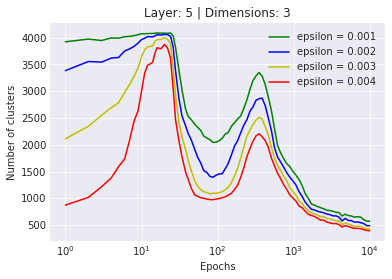

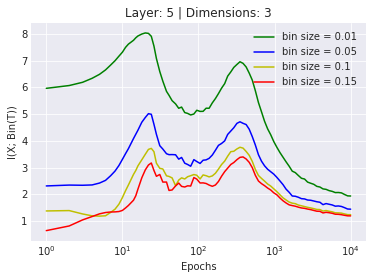

In [356]:
nclusters1 = get_connected_components(epsilon = 0.0012)   #eps = 0.03 (max dist),  4(min_samples)
nclusters2 = get_connected_components(epsilon = 0.002)
nclusters3 = get_connected_components(epsilon = 0.003)
nclusters4 = get_connected_components(epsilon = 0.004)

binned_mi1 = get_binned_MI(binsize = 0.01)
binned_mi2 = get_binned_MI(binsize = 0.05)
binned_mi3 = get_binned_MI(binsize = 0.1)
binned_mi4 = get_binned_MI(binsize = 0.15)

fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters1, 'g', label = 'epsilon = 0.001')
plt.semilogx(epoch_subsample, nclusters2, 'b', label = 'epsilon = 0.002')
plt.semilogx(epoch_subsample, nclusters3, 'y', label = 'epsilon = 0.003')
plt.semilogx(epoch_subsample, nclusters4, 'r', label = 'epsilon = 0.004')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 5 | Dimensions: 3')
plt.savefig('Layer5_3_nclusters.png')
plt.figure()
plt.semilogx(epoch_subsample, binned_mi1, 'g', label = 'bin size = 0.01')
plt.semilogx(epoch_subsample, binned_mi2, 'b', label = 'bin size = 0.05')
plt.semilogx(epoch_subsample, binned_mi3, 'y', label = 'bin size = 0.1')
plt.semilogx(epoch_subsample, binned_mi4, 'r', label = 'bin size = 0.15')
plt.ylabel('I(X; Bin(T))')
plt.xlabel('Epochs')
plt.title('Layer: 5 | Dimensions: 3')
plt.legend()
plt.savefig('Layer5_3_binnedmi.png')
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters2, binned_mi2))

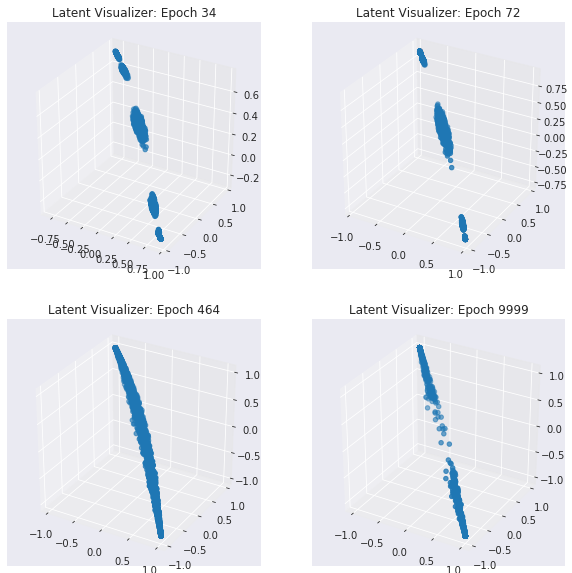

In [117]:
layer = data_tishby[-2]
activity = layer[22,:,:]
#fig, ax = plt.subplots(211)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(activity[:,0],
           activity[:,1], 
           activity[:,2])
ax.title.set_text('Latent Visualizer: Epoch ' + str(epoch_subsample[22]))

activity = layer[30,:,:]
#fig2 = plt.figure(figsize=(5,5))
ax = fig.add_subplot(222, projection='3d')
ax.scatter(activity[:,0],
           activity[:,1], 
           activity[:,2])
ax.title.set_text('Latent Visualizer: Epoch '+ str(epoch_subsample[30]))

activity = layer[50,:,:]
#fig2 = plt.figure(figsize=(5,5))
ax = fig.add_subplot(223, projection='3d')
ax.scatter(activity[:,0],
           activity[:,1], 
           activity[:,2])
ax.title.set_text('Latent Visualizer: Epoch '+ str(epoch_subsample[50]))

activity = layer[83,:,:]
#fig3 = plt.figure(figsize=(5,5))
ax = fig.add_subplot(224, projection='3d')
ax.scatter(activity[:,0],
           activity[:,1], 
           activity[:,2])
ax.title.set_text('Latent Visualizer: Epoch '+ str(epoch_subsample[83]))
plt.savefig('Epoch_activations.png')

_Layer 4 (Dims: 4)_

In [174]:
#Heuristic for  epsilon 

# points = data_tishby[-3][0,:,:]
# M_d = spatial.distance_matrix(points,
#                               points,
#                               p=2)**2
# np.median(M_d[np.tril_indices(points.shape[0], k = -1)])

In [175]:
points = data_tishby[-3][0,:,:]
M_d = spatial.distance_matrix(points,
                              points,
                              p=2)**2

(0.014655863527732432, 0.0019305157367488937, 0.00694174922604507)

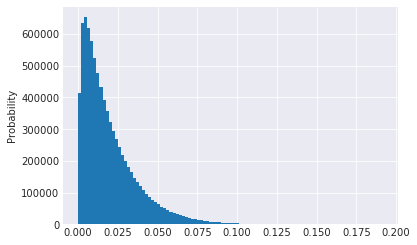

In [176]:
dists = M_d[np.tril_indices(points.shape[0], k = -1)]
%matplotlib inline
plt.hist(dists,  bins=100)
plt.ylabel('Probability');
np.median(dists), np.quantile(dists, 0.05), np.quantile(dists, 0.25)

Correlation between binned MI and number of clusters:  (0.7881888077830397, 5.71260033464283e-19)


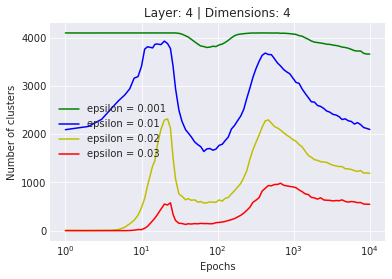

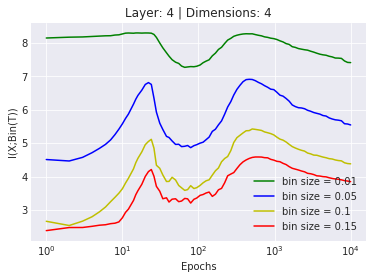

In [177]:
nclusters1 = get_nclusters(epsilon = 0.001, lndx = -3)
nclusters2 = get_nclusters(epsilon = 0.01, lndx = -3)   #eps = 0.03 (max dist),  4(min_samples)
nclusters3 = get_nclusters(epsilon = 0.02, lndx = -3)
nclusters4 = get_nclusters(epsilon = 0.03, lndx = -3)


binned_mi1 = get_binned_MI(binsize = 0.01, lndx = -3)
binned_mi2 = get_binned_MI(binsize = 0.05, lndx = -3)
binned_mi3 = get_binned_MI(binsize = 0.1, lndx = -3)
binned_mi4 = get_binned_MI(binsize = 0.15, lndx = -3)


fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters1, 'g', label = 'epsilon = 0.001')
plt.semilogx(epoch_subsample, nclusters2, 'b', label = 'epsilon = 0.01')
plt.semilogx(epoch_subsample, nclusters3, 'y', label = 'epsilon = 0.02')
plt.semilogx(epoch_subsample, nclusters4, 'r', label = 'epsilon = 0.03')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 4 | Dimensions: 4')
plt.savefig('Layer4_4_nclusters.png')

plt.figure()
plt.semilogx(epoch_subsample, binned_mi1, 'g', label = 'bin size = 0.01')
plt.semilogx(epoch_subsample, binned_mi2, 'b', label = 'bin size = 0.05')
plt.semilogx(epoch_subsample, binned_mi3, 'y', label = 'bin size = 0.1')
plt.semilogx(epoch_subsample, binned_mi4, 'r', label = 'bin size = 0.15')
plt.ylabel('I(X;Bin(T))')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 4 | Dimensions: 4')
plt.savefig('Layer4_4_binnedmi.png')
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters2, binned_mi2))

_Layer 3 (Dims = 5)_

In [171]:
points = data_tishby[-4][0,:,:]
M_d = spatial.distance_matrix(points,
                              points,
                              p=2)**2
np.mean(M_d[np.tril_indices(points.shape[0], k = -1)])

0.07785093084330759

0.010024338575043906

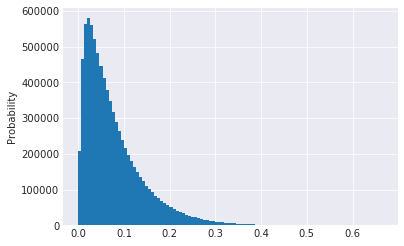

In [172]:
dists = M_d[np.tril_indices(points.shape[0], k = -1)]
%matplotlib inline
plt.hist(dists,  bins=100)
plt.ylabel('Probability');
np.quantile(dists, 0.05)

Correlation between binned MI and number of clusters:  (0.7601358362229529, 5.070964946150402e-17)


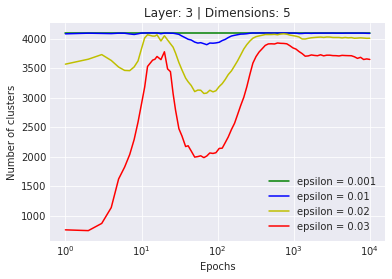

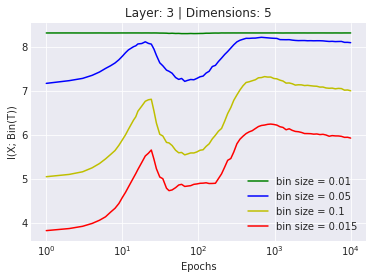

In [173]:
nclusters1 = get_nclusters(epsilon = 0.001, lndx = -4)
nclusters2 = get_nclusters(epsilon = 0.01, lndx = -4)   #eps = 0.03 (max dist),  4(min_samples)
nclusters3 = get_nclusters(epsilon = 0.02, lndx = -4)
nclusters4 = get_nclusters(epsilon = 0.03, lndx = -4)

binned_mi1 = get_binned_MI(binsize = 0.01, lndx = -4)
binned_mi2 = get_binned_MI(binsize = 0.05, lndx = -4)
binned_mi3 = get_binned_MI(binsize = 0.1, lndx = -4)
binned_mi4 = get_binned_MI(binsize = 0.15, lndx = -4)

fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters1, 'g', label = 'epsilon = 0.001')
plt.semilogx(epoch_subsample, nclusters2, 'b', label = 'epsilon = 0.01')
plt.semilogx(epoch_subsample, nclusters3, 'y', label = 'epsilon = 0.02')
plt.semilogx(epoch_subsample, nclusters4, 'r', label = 'epsilon = 0.03')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 3 | Dimensions: 5')
plt.savefig('Layer3_5_nclusters.png')



plt.figure()
plt.semilogx(epoch_subsample, binned_mi1, 'g', label = 'bin size = 0.01')
plt.semilogx(epoch_subsample, binned_mi2, 'b', label = 'bin size = 0.05')
plt.semilogx(epoch_subsample, binned_mi3, 'y', label = 'bin size = 0.1')
plt.semilogx(epoch_subsample, binned_mi4, 'r', label = 'bin size = 0.015')
plt.ylabel('I(X; Bin(T))')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 3 | Dimensions: 5')
plt.savefig('Layer3_5_binnedmi.png')

print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters2, binned_mi2))

# Layer 2 (Dims 7)

In [153]:
points = data_tishby[1][0,:,:]
M_d = spatial.distance_matrix(points,
                              points,
                              p=2)**2

0.05598632888360828

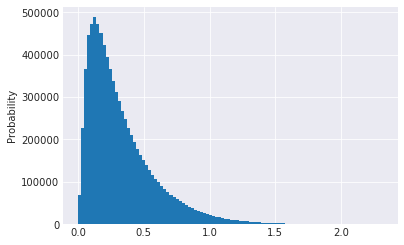

In [154]:
dists = M_d[np.tril_indices(points.shape[0], k = -1)]
%matplotlib inline
plt.hist(dists,  bins=100)
plt.ylabel('Probability');
np.quantile(dists, 0.05)

Correlation between binned MI and number of clusters:  (-0.031749303055875755, 0.7743425451341864)


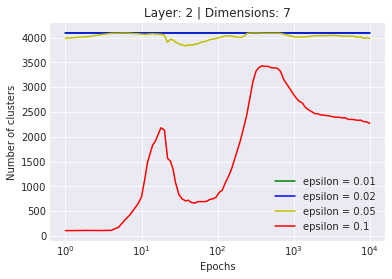

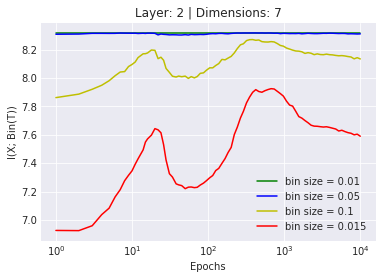

In [169]:
nclusters1 = get_nclusters(epsilon = 0.01, lndx = -5)
nclusters2 = get_nclusters(epsilon = 0.02, lndx = -5)   #eps = 0.03 (max dist),  4(min_samples)
nclusters3 = get_nclusters(epsilon = 0.05, lndx = -5)
nclusters4 = get_nclusters(epsilon = 0.1, lndx = -5)

binned_mi1 = get_binned_MI(binsize = 0.01, lndx = -5)
binned_mi2 = get_binned_MI(binsize = 0.05, lndx = -5)
binned_mi3 = get_binned_MI(binsize = 0.1, lndx = -5)
binned_mi4 = get_binned_MI(binsize = 0.15, lndx = -5)

fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters1, 'g', label = 'epsilon = 0.01')
plt.semilogx(epoch_subsample, nclusters2, 'b', label = 'epsilon = 0.02')
plt.semilogx(epoch_subsample, nclusters3, 'y', label = 'epsilon = 0.05')
plt.semilogx(epoch_subsample, nclusters4, 'r', label = 'epsilon = 0.1')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 2 | Dimensions: 7')
plt.savefig('Layer2_7_nclusters.png')



plt.figure()
plt.semilogx(epoch_subsample, binned_mi1, 'g', label = 'bin size = 0.01')
plt.semilogx(epoch_subsample, binned_mi2, 'b', label = 'bin size = 0.05')
plt.semilogx(epoch_subsample, binned_mi3, 'y', label = 'bin size = 0.1')
plt.semilogx(epoch_subsample, binned_mi4, 'r', label = 'bin size = 0.015')
plt.ylabel('I(X; Bin(T))')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 2 | Dimensions: 7')
plt.savefig('Layer2_7_binnedmi.png')

print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters2, binned_mi2))

Correlation between binned MI and number of clusters:  (0.9446784174075338, 1.858839850581651e-41)


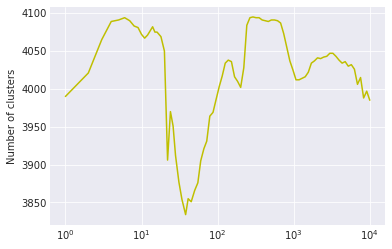

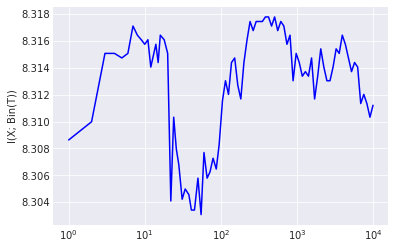

In [170]:
nclusters = get_nclusters(epsilon = 0.05, lndx = -5)   #eps = 0.03 (max dist),  4(min_samples)
binned_mi = get_binned_MI(binsize = 0.05, lndx = -5)
fig = plt.figure()
plt.semilogx(epoch_subsample, nclusters, 'y')
plt.ylabel('Number of clusters')
plt.savefig('Layer2_7_nclusters_zoomed.png')
plt.figure()
plt.semilogx(epoch_subsample, binned_mi, 'b')
plt.ylabel('I(X; Bin(T))')
plt.savefig('Layer2_7_binnedmi_zommed.png')
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters, binned_mi))

# MNIST

In [182]:
ARCH = '1024-20-20-20'
DIR_TEMPLATE = '%%s_%s'%ARCH
activation = 'tanh'
cur_dir = 'ibsgd/rawdata/' + DIR_TEMPLATE % activation

In [183]:
 ##lndx = -2, binsize = 0.07/0.1, eps = 0.3, min_samples = 20

def get_nclusters(epsilon = 0.32, min_samples = 1, lndx = -2):
    nb_clusters = []
    for epochfile in sorted(os.listdir(cur_dir)):
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
                d = pickle.load(f)

        activity = d['data']['activity_tst'][lndx]
        #binned_mi = bin_calc_information2(activity, binsize)
        #binxm.append(binned_mi)

        clustering = DBSCAN(eps = epsilon, min_samples=min_samples).fit(activity)
        y_pred = clustering.labels_
        cluster_labels = np.unique(y_pred)


        if -1 in cluster_labels:
            nclusters = len(cluster_labels)-1
        else:
            nclusters = len(cluster_labels)
        nb_clusters.append(nclusters)
        print(nclusters)
        #print(np.count_nonzero(y_pred!=-1))
    return nb_clusters

In [184]:
def get_binned_MI(binsize=0.1, lndx = -2):
    def get_unique_probs(x):
        uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
        _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
        return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


    def bin_calc_information2(layerdata, binsize):
        # This is even further simplified, where we use np.floor instead of digitize
        def get_h(d):
            digitized = np.floor(d / binsize).astype('int')
            p_ts, _ = get_unique_probs( digitized )
            return -np.sum(p_ts * np.log(p_ts))

        H_LAYER = get_h(layerdata)
        return H_LAYER
    binxm = []
    for epochfile in sorted(os.listdir(cur_dir)):
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
                d = pickle.load(f)

        activity = d['data']['activity_tst'][lndx]
        binned_mi = bin_calc_information2(activity, binsize)
        binxm.append(binned_mi)
    return np.asarray(binxm)

In [190]:
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[0]

with open(fname, 'rb') as f:
        d = pickle.load(f)
        epochs.append(d['epoch'])
activity = d['data']['activity_tst'][-2]

In [194]:
epochs = []
for i in range(len(epochfiles)):
    fname = cur_dir + "/" + epochfiles[i]
    with open(fname, 'rb') as f:
        d = pickle.load(f)
        epochs.append(d['epoch'])

In [186]:
M_d = spatial.distance_matrix(activity,
                              activity,
                              p=2)**2


0.4824378740099253

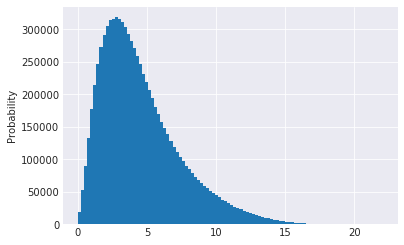

In [187]:
dists = M_d[np.tril_indices(points.shape[0], k = -1)]
%matplotlib inline
plt.hist(dists,  bins=100)
plt.ylabel('Probability');
np.quantile(dists, 0.01)

In [192]:
epochs

[0]

Correlation between binned MI and number of clusters:  (0.9446784174075338, 1.858839850581651e-41)


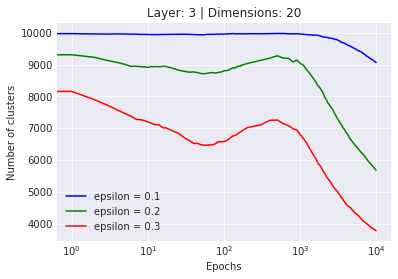

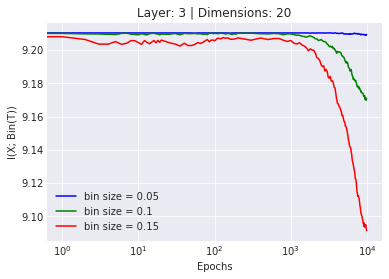

In [198]:
# nclusters1 = get_nclusters(epsilon = 0.1, lndx = -2)   #eps = 0.03 (max dist),  4(min_samples)
# nclusters2 = get_nclusters(epsilon = 0.2, lndx = -2) 
# nclusters3 = get_nclusters(epsilon = 0.3, lndx = -2) 
# binned_mi1 = get_binned_MI(binsize = 0.05, lndx = -2)
# binned_mi2 = get_binned_MI(binsize = 0.1, lndx = -2)
# binned_mi3 = get_binned_MI(binsize = 0.15, lndx = -2)
plt.figure()
plt.semilogx(epochs, nclusters1, 'b', label = 'epsilon = 0.1')
plt.semilogx(epochs, nclusters2, 'g', label = 'epsilon = 0.2')
plt.semilogx(epochs, nclusters3, 'r', label = 'epsilon = 0.3')
plt.ylabel('Number of clusters')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 3 | Dimensions: 20')
plt.savefig('Layer3_20_nclusters_MNIST.png')


plt.figure()
plt.semilogx(epochs, binned_mi1, 'b', label = 'bin size = 0.05')
plt.semilogx(epochs, binned_mi2, 'g', label = 'bin size = 0.1')
plt.semilogx(epochs, binned_mi3, 'r', label = 'bin size = 0.15')
plt.ylabel('I(X; Bin(T))')
plt.xlabel('Epochs')
plt.legend()
plt.title('Layer: 3 | Dimensions: 20')
plt.savefig('Layer3_20_binnedmi_MNIST.png')


print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters, binned_mi))


In [ ]:
nclusters = get_nclusters(epsilon = 0.22, lndx = -2)   #eps = 0.03 (max dist),  4(min_samples)
binned_mi = get_binned_MI(binsize = 0.1, lndx = -2)
plt.figure()
plt.plot(nclusters, 'r')
plt.figure()
plt.plot(binned_mi)
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters, binned_mi))


In [ ]:
nclusters = get_nclusters(epsilon = 0.25, lndx = -2)   #eps = 0.03 (max dist),  4(min_samples)
binned_mi = get_binned_MI(binsize = 0.1, lndx = -2)
plt.figure()
plt.plot(nclusters, 'r')
plt.figure()
plt.plot(binned_mi)
print('Correlation between binned MI and number of clusters: ', pearsonr(nclusters, binned_mi))


In [ ]:
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[0]
with open(fname, 'rb') as f:
        d = pickle.load(f)
        epoch_no = d['epoch']
activity = d['data']['activity_tst'][lndx]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111) 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activity)
ax.scatter(tsne_results[:,0], tsne_results[:,1])
ax.title.set_text('Epoch '+ str(epoch_no))

In [ ]:
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[40]
with open(fname, 'rb') as f:
        d = pickle.load(f)
        epoch_no = d['epoch']
activity = d['data']['activity_tst'][lndx]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111) 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activity)
ax.scatter(tsne_results[:,0], tsne_results[:,1])
ax.title.set_text('Epoch '+ str(epoch_no))

In [ ]:
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[-1]
with open(fname, 'rb') as f:
        d = pickle.load(f)
        epoch_no = d['epoch']
activity = d['data']['activity_tst'][lndx]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111) 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activity)
ax.scatter(tsne_results[:,0], tsne_results[:,1])
ax.title.set_text('Epoch '+ str(epoch_no))

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111) 
# ax.scatter(tsne_results[:,0][y_pred!=-1], tsne_results[:,1][y_pred!=-1], c = y_pred[y_pred!=-1])

In [ ]:
lndx = -3
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[-1]
with open(fname, 'rb') as f:
        d = pickle.load(f)

activity = d['data']['activity_tst'][lndx]
clustering = DBSCAN(eps=0.5, min_samples=20).fit(activity)
y_pred = clustering.labels_
cluster_labels = np.unique(y_pred)
if -1 in cluster_labels:
    nclusters = len(cluster_labels)-1
else:
    nclusters = len(cluster_labels)
print(nclusters)
print(np.count_nonzero(y_pred==-1)/len(y_pred))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111) 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activity)
ax.scatter(tsne_results[:,0][y_pred!=-1], tsne_results[:,1][y_pred!=-1], c = y_pred[y_pred!=-1])
#ax.scatter(tsne_results[:,0][y_pred!=-1], tsne_results[:,1][y_pred!=-1], c = y_pred[y_pred!=-1])

# t-SNE based MI estimation on Tishby data

In [ ]:
binsize = 0.07

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


def bin_calc_information2(layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    return H_LAYER


In [ ]:
nb_clusters = []
lndx = -2

data_tishby = np.load('/home/zz452/cluster/data/modelTishby_0_layer_data.p')
layer = data_tishby[lndx] 
binxm_low = np.zeros(84)
binxm = np.zeros(84)
binsize_low = np.exp(1.5*np.log(binsize))
for idx in range(len(layer)):
    X = layer[idx,:,:]
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    binxm_low[idx] =  bin_calc_information2(tsne_results, binsize)
    binxm[idx] = bin_calc_information2(X, binsize)

In [ ]:
# binsize = 0.5
# binxm = np.zeros(84)
# for idx in range(len(layer)):
#     X = layer[idx,:,:]
#     binxm[idx] = bin_calc_information2(X, binsize)
# plt.plot(binxm)

In [ ]:
#plt.plot(binxm)
#plt.plot(binxm_low, 'r')

# Saxe Tishby Model with tanh

In [ ]:
ARCH = '10-7-5-4-3'
DIR_TEMPLATE = '%%s_%s'%ARCH
activation = 'tanh'
cur_dir = 'ibsgd/rawdata/' + DIR_TEMPLATE % activation

In [ ]:
lndx = -3  ##lndx = -2, binsize = 0.07/0.1, eps = 0.3, min_samples = 20
binxm = []
nb_clusters = []
binsize = 0.07
#scores = []
for epochfile in sorted(os.listdir(cur_dir)):
    fname = cur_dir + "/" + epochfile
    with open(fname, 'rb') as f:
            d = pickle.load(f)
            
    activity = d['data']['activity_tst'][lndx]
    binned_mi = bin_calc_information2(activity, binsize)
    binxm.append(binned_mi)
    
    clustering = DBSCAN(eps = 0.12, min_samples=10).fit(activity)
    y_pred = clustering.labels_
    cluster_labels = np.unique(y_pred)
    
    
    if -1 in cluster_labels:
        nclusters = len(cluster_labels)-1
    else:
        nclusters = len(cluster_labels)
    nb_clusters.append(nclusters)
    print(activity.shape, binned_mi, nclusters, np.count_nonzero(y_pred==-1)/len(y_pred))
    
print('Correlation between binned MI and no of clusters: ', pearsonr(nb_clusters, binxm))    

In [ ]:
plt.figure()
plt.plot(nb_clusters, 'r')
plt.figure()
plt.plot(binxm)

In [ ]:
epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[160]
with open(fname, 'rb') as f:
        d = pickle.load(f)

activity = d['data']['activity_tst'][lndx]
clustering = DBSCAN(eps=0.1, min_samples=4).fit(activity)
y_pred = clustering.labels_
cluster_labels = np.unique(y_pred)
if -1 in cluster_labels:
    nclusters = len(cluster_labels)-1
else:
    nclusters = len(cluster_labels)
print(nclusters)
print(np.count_nonzero(y_pred==-1)/len(y_pred))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(activity[:,0][y_pred!=-1],
           activity[:,1][y_pred!=-1], 
           activity[:,2][y_pred!=-1], c = y_pred[y_pred!=-1])
ax.title.set_text('Latent Visualizer')


# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111) 
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(activity)
# ax.scatter(tsne_results[:,0][y_pred!=-1], tsne_results[:,1][y_pred!=-1], c = y_pred[y_pred!=-1])

# Saxe Tishby Model with ReLU

In [ ]:
# Correct binned MI for Tishby Model

In [ ]:
ARCH = '10-7-5-4-3'
DIR_TEMPLATE = '%%s_%s'%ARCH
activation = 'relu'
cur_dir = 'ibsgd/rawdata/' + DIR_TEMPLATE % activation

In [ ]:
lndx = -4  ##lndx = -2, binsize = 0.07/0.1, eps = 0.3, min_samples = 20
binxm = []
nb_clusters = []
binsize = 0.05
#scores = []
for epochfile in sorted(os.listdir(cur_dir)):
    fname = cur_dir + "/" + epochfile
    with open(fname, 'rb') as f:
            d = pickle.load(f)
            
    activity = d['data']['activity_tst'][lndx]
    binned_mi = bin_calc_information2(activity, binsize)
    binxm.append(binned_mi)
    
    clustering = DBSCAN(eps = 0.32, min_samples=10).fit(activity)
    y_pred = clustering.labels_
    cluster_labels = np.unique(y_pred)
    
    
    if -1 in cluster_labels:
        nclusters = len(cluster_labels)-1
    else:
        nclusters = len(cluster_labels)
    nb_clusters.append(nclusters)
    print(activity.shape, binned_mi, nclusters, np.count_nonzero(y_pred==-1)/len(y_pred))
    
print('Correlation between binned MI and no of clusters: ', pearsonr(nb_clusters, binxm))    

In [ ]:
plt.plot(nb_clusters, 'r')
plt.figure()
plt.plot(binxm)
print('Correlation between binned MI and no of clusters: ', pearsonr(nb_clusters[120:], binxm[120:]))    

In [ ]:
#epochfiles = sorted(os.listdir(cur_dir))
fname = cur_dir + "/" + epochfiles[0]
with open(fname, 'rb') as f:
        d = pickle.load(f)

activity = d['data']['activity_tst'][lndx]


clustering = DBSCAN(eps=0.3, min_samples=10).fit(activity)
y_pred = clustering.labels_
cluster_labels = np.unique(y_pred)
if -1 in cluster_labels:
    nclusters = len(cluster_labels)-1
else:
    nclusters = len(cluster_labels)
print(nclusters)
print(np.count_nonzero(y_pred==-1)/len(y_pred))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(activity[:,0],
           activity[:,1], 
           activity[:,2])
ax.title.set_text('Latent Visualizer')

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111) 
# tsne = TSNE(n_components=2, verbose=1, perplexity=300, n_iter=300)
# tsne_results = tsne.fit_transform(activity)
# ax.scatter(tsne_results[:,0], tsne_results[:,1], c = y_pred)